# plotting hovmoller for given spectral index
- bring in transect
- view in ipyleaflet
- load in datacube data
- make into pandas df
- change distances to meters (* 30)
- make sure seaward end is aways first TODO
- export as csv and plot up through pandas (not xarray) and export plot TODO
- make into func to loop through for multiple inputs TODO

In [1]:
%matplotlib inline
import os, sys

import numpy as np
import xarray as xr
import rasterio
import geopandas as gpd
import fiona

import shapely.geometry
from shapely.geometry import shape

import matplotlib.gridspec as gridspec
import matplotlib as mpl
from matplotlib import colors
from matplotlib import pyplot as plt
import matplotlib.dates

import datacube
from datacube.utils import geometry
from datacube.drivers.netcdf import write_dataset_to_netcdf
dc = datacube.Datacube(app='mangrove typology')

from dea_tools.datahandling import load_ard
from dea_tools.plotting import display_map
from dea_tools.bandindices import calculate_indices

sys.path.insert(1, '/home/jovyan/code/DP_KNP/misc_funcs')
from plotting_CO import display_map_line

In [2]:
# This defines the function that converts a linear vector file into a string of x,y coordinates

def geom_query(geom, geom_crs='EPSG:4326'):
    """
    Create datacube query snippet for geometry
    """
    return {
        'x': (geom.bounds[0], geom.bounds[2]),
        'y': (geom.bounds[1], geom.bounds[3]),
        'crs': geom_crs
    }

def warp_geometry(geom, crs_crs, dst_crs):
    """
    warp geometry from crs_crs to dst_crs
    """
    return shapely.geometry.shape(rasterio.warp.transform_geom(crs_crs, dst_crs, shapely.geometry.mapping(geom)))

In [3]:
# need to be WGS84 coordinate system for transects
transect_file = './OpenCoastTransectGulf/T1.shp'

In [4]:
# Define temporal range
start_of_epoch = '1990-01-01' 
end_of_epoch =  '2020-12-31'
print ('temporal range is ' + start_of_epoch + ' to ' + end_of_epoch)

temporal range is 1990-01-01 to 2020-12-31


In [5]:
# use fiona module to open the shape file
transect = fiona.open(transect_file)

geom_ = shape(transect[0]['geometry'])
geom_query_ = geom_query(geom=geom_)

query = {'time': (start_of_epoch, end_of_epoch)}

query.update(geom_query(geom=geom_, geom_crs=transect.crs_wkt))

In [6]:
display_map_line(query['x'], query['y'])

In [7]:
%%time
# select the spectral index you want
index_selection = 'NDVI'

ds = load_ard(dc=dc, 
              products=['ga_ls5t_ard_3', 'ga_ls7e_ard_3', 'ga_ls8c_ard_3'],
              measurements=['nbart_blue', 'nbart_green', 'nbart_red', 'nbart_nir', 'nbart_swir_1', 'nbart_swir_2'], 
              min_gooddata=0.99, 
              output_crs='EPSG:3577',
              skip_broken_datasets=True,
              ls7_slc_off=True,
              resolution=(-30, 30),
              group_by='solar_day',
              **query)

ds_index = calculate_indices(ds,
                       index=index_selection,
                       collection='ga_ls_3',
                       drop=True,
                       inplace=False)

ds_index = ds_index[index_selection]

Finding datasets
    ga_ls5t_ard_3
    ga_ls7e_ard_3
    ga_ls8c_ard_3
Counting good quality pixels for each time step using fmask


/env/lib/python3.10/site-packages/rasterio/warp.py:344: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  _reproject(


Filtering to 350 out of 917 time steps with at least 99.0% good quality pixels
Applying fmask pixel quality/cloud mask
Loading 350 time steps
Dropping bands ['nbart_blue', 'nbart_green', 'nbart_red', 'nbart_nir', 'nbart_swir_1', 'nbart_swir_2']
CPU times: user 9min 11s, sys: 3min 25s, total: 12min 37s
Wall time: 13min 53s


In [8]:
# Compress 
crs_wkt = ds.crs
geom_w = warp_geometry(geom_, query['crs'], crs_wkt)

In [9]:
dist = [i for i in range(0, int(geom_w.length), 30)]

points = list(zip(*[geom_w.interpolate(d).coords[0] for d in dist])) # py3

In [10]:
y_dim = np.asarray(points[1])
x_dim = np.asarray(points[0])

hov_data = ds_index.sel(x=xr.DataArray(x_dim, dims='distance'),
                        y=xr.DataArray(y_dim, dims='distance'),
                        method='nearest')

In [11]:
# Convert DataArray to DataFrame
df = hov_data.to_dataframe(name='value').reset_index()

# Pivot the DataFrame
df_pivoted = df.pivot(index='time', columns='distance', values='value')
# make column headings into meters (* 30)
df_pivoted.columns = (df_pivoted.columns.astype(int) * 30).astype(str)

df_pivoted

distance,0,30,60,90,120,150,180,210,240,270,...,540,570,600,630,660,690,720,750,780,810
time,,,,,,,,,,,,,,,,,,,,,
1990-02-03 00:20:21.947853,0.692405,0.659689,0.647204,0.622442,0.696793,0.656149,0.659158,0.571304,0.634250,0.687453,...,0.244993,0.184659,0.192344,0.223443,0.219170,0.219170,0.025818,-0.090493,-0.093909,-0.200577
1990-04-24 00:18:42.877239,0.701933,0.676774,0.667808,0.647337,0.760412,0.739492,0.713900,0.627619,0.683504,0.748970,...,0.236492,0.143624,-0.065167,-0.286458,-0.481371,-0.481371,-0.516484,-0.532909,-0.574365,-0.554994
1990-06-11 00:18:39.331455,0.699073,0.688191,0.683496,0.680782,0.735230,0.735725,0.664077,0.642441,0.736249,0.753450,...,0.233101,0.086070,-0.242365,-0.476088,-0.490257,-0.490257,-0.453795,-0.432733,-0.409982,-0.481273
1990-08-14 00:18:27.188542,0.588632,0.595318,0.603069,0.651172,0.744311,0.687398,0.661297,0.627001,0.688411,0.731996,...,0.189332,0.147826,0.157330,0.169972,0.145960,0.145960,0.159085,0.062271,0.044476,-0.177724
1990-08-30 00:18:20.289931,0.555933,0.535691,0.525694,0.569954,0.613759,0.549275,0.552995,0.532507,0.589952,0.632736,...,0.196856,0.172248,0.176216,0.175758,0.116718,0.116718,-0.103629,-0.251287,-0.293592,-0.328302
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-08-16 00:58:29.649785,0.638470,0.634442,0.668810,0.712046,0.767037,0.811024,0.783633,0.716989,0.785872,0.821796,...,0.250000,0.142383,-0.519492,-0.661915,-0.693798,-0.693798,-0.756046,-0.748826,-0.747958,-0.762238
2020-09-01 00:58:37.839027,0.609195,0.604816,0.642586,0.694176,0.753278,0.799031,0.766626,0.699208,0.780607,0.801476,...,0.238601,0.122382,-0.582834,-0.712264,-0.736018,-0.736018,-0.764972,-0.730769,-0.725191,-0.741117
2020-09-09 00:24:47.547448,0.588172,0.594674,0.622978,0.706466,0.767662,0.765442,0.751741,0.715471,0.754221,0.765706,...,0.209410,0.118384,-0.019212,-0.019710,-0.069547,-0.069547,-0.404935,-0.392027,-0.410153,-0.453311


In [12]:
# This controls the colour map used for plotting NDVI
ndvi_cmap = mpl.colors.ListedColormap(['blue', '#ffcc66','#ffffcc' , '#ccff66' , '#2eb82e', '#009933' , '#006600'])
ndvi_bounds = [-1, 0, 0.1, 0.25, 0.35, 0.5, 0.8, 1]

ndvi_norm = mpl.colors.BoundaryNorm(ndvi_bounds, ndvi_cmap.N, clip=True)

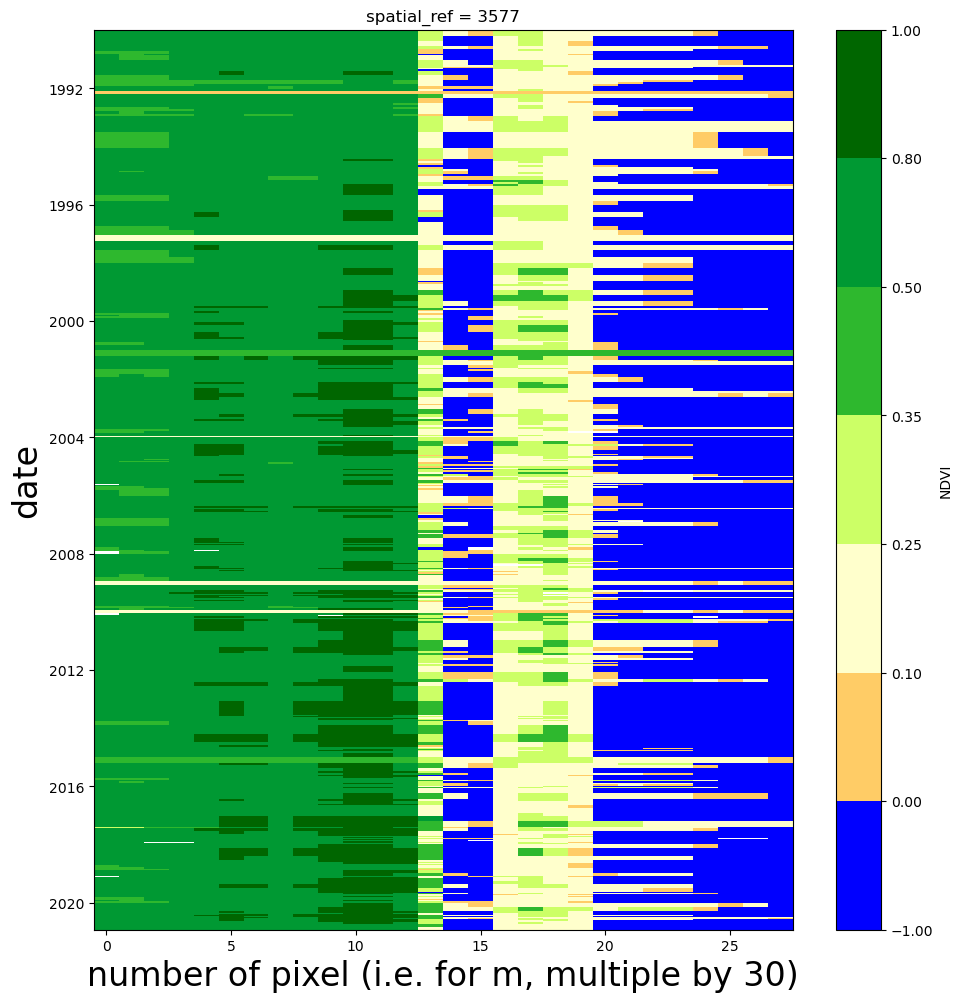

In [13]:
fig = plt.figure(figsize=(11.27,11.69))

hov_data.plot(x='distance', y='time', yincrease = False, cmap = ndvi_cmap, norm = ndvi_norm, vmin=-1, vmax =1)
# plt.axis([0, hov_multi_ndvi_sel.distance.max(), '2010-01-01' , '2020-01-01'])
matplotlib.rcParams.update({'font.size': 10})

# plt.suptitle(shape_name.replace('_',' '), fontsize ='24')

plt.xlabel('number of pixel (i.e. for m, multiple by 30)', fontsize ='24')
plt.ylabel('date', fontsize ='24')


#save plot to file
# plt.savefig('{}{}_HovPlot_{}_{}.png'.format(savepath,shape_name,start_of_epoch,end_of_epoch),
#             bbox_inches='tight', dpi=300)
plt.show()